In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2020-02-28 13:46:32--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2020-02-28 13:46:33--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  10.1MB/s    in 5m 43s  

2020-02-28 13:52:16 (9.83 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [0]:
import  os,shutil
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [0]:
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png  
  infl

In [0]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [0]:
img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = cv2.imread(i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_crop = crop_center(img,256,256)
    img_list.append(img_crop)
    img_low_list.append(cv2.resize(img_crop,(64,64)))

high_reso_imgs = np.array(img_list)
low_reso_imgs = np.array(img_low_list)

In [0]:
print(low_reso_imgs)

[[[[206 206 216]
   [206 206 216]
   [206 206 216]
   ...
   [206 209 218]
   [206 209 218]
   [206 209 218]]

  [[206 206 216]
   [206 206 216]
   [206 206 216]
   ...
   [205 207 219]
   [206 208 220]
   [206 208 220]]

  [[206 206 216]
   [206 206 216]
   [206 206 216]
   ...
   [206 209 218]
   [205 208 217]
   [206 209 218]]

  ...

  [[205 208 217]
   [205 208 217]
   [205 208 217]
   ...
   [205 208 217]
   [205 208 217]
   [206 208 218]]

  [[204 207 216]
   [205 208 217]
   [205 208 217]
   ...
   [205 208 217]
   [206 209 219]
   [206 208 218]]

  [[205 208 217]
   [204 207 216]
   [205 208 217]
   ...
   [205 208 217]
   [205 208 218]
   [205 207 218]]]


 [[[  9  11   9]
   [ 10  12  12]
   [  9  11  10]
   ...
   [  6   6   6]
   [  5   7   7]
   [  6   6   7]]

  [[  8  11  11]
   [  9  12  10]
   [  9  11   7]
   ...
   [  4   6   4]
   [  5   7   4]
   [  6   6   6]]

  [[  9  11  12]
   [  9  10  11]
   [ 10  11   8]
   ...
   [  6   6   6]
   [  5   7   5]
   [  5   6

In [0]:
os.chdir('/content')

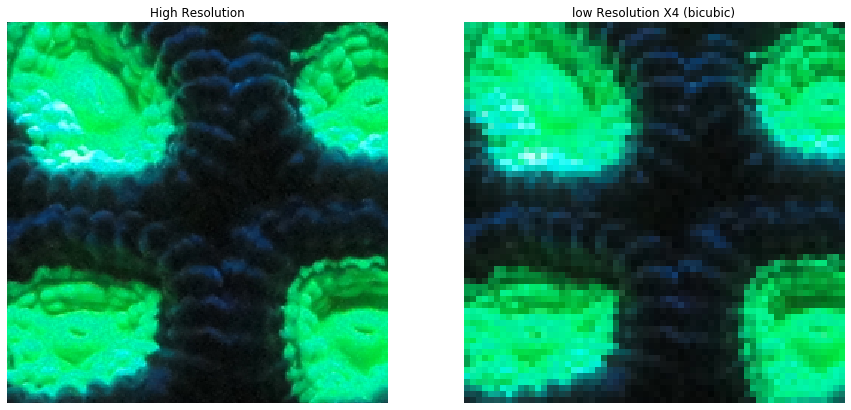

In [0]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2],(64,64),
                      interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')

In [0]:
class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 64,lr_width = 64,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            
            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)
            
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            
            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):
        vgg = VGG19(weights = "imagenet")
#         vgg.summary()
        vgg.outputs = [vgg.layers[9].output]
        img = Input(shape = self.shape_high_reso)
        img_features = vgg(img)
        vgg_model = Model(img, img_features)
#         for layer in vgg_model.layers:
#             layer.trainable = False
        vgg_model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),
                         metrics =['acc'])
        return vgg_model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.depth_to_space(x, scale))
  
    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)
        
        output_residual = BatchNormalization(momentum=0.8)(output_residual)
        
        output_residual = Add()([output_residual,first_layer])
               
        upsample_layer = self.Upsample_Block(output_residual)
        
        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)
            
        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks, 
                                             n_filters = (i+1)*2*n_filters)
        
        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)


        gan_model = Model(inputs = [gen_input, dis_input], 
                          outputs = [generator_valid, generated_features])
        
        for l in gan_model.layers[-1].layers[-1].layers:
          l.trainable=False
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        
        return gan_model



    def train(self, epochs, save_interval = 100, batch_size = 16):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            if epo % save_interval == 0:
              self.save_GAN_Model(epo)
              self.plotLosses(dlosses,glosses,epo)
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])

In [0]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
        
        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
        
    plt.savefig('predicted.png')

In [0]:
model_srgan = SRGAN()





574717952/574710816 [==============================] - 13s 0us/step










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  11252995    input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    3759681     model_3[1][0]                    
__________________________________________________________________________________________________
model_1 (Model)

In [0]:
model_srgan.generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, 64, 64)   262144      conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

In [0]:
model_srgan.discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     7385

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
os.chdir('/content')
!mkdir training_process
os.chdir('./training_process')

--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 2.7567704 28.461653
--------------- Epoch 2 ---------------




 3.3793504 22.319527
--------------- Epoch 3 ---------------




 3.2315295 19.455545
--------------- Epoch 4 ---------------




 3.9941058 16.40674
--------------- Epoch 5 ---------------




 4.236353 21.294336
--------------- Epoch 6 ---------------




 4.313257 19.22551
--------------- Epoch 7 ---------------




 4.3999844 16.657705
--------------- Epoch 8 ---------------




 4.317976 18.222189
--------------- Epoch 9 ---------------




 4.5911503 15.089181
--------------- Epoch 10 ---------------




 4.5747585 20.20017
--------------- Epoch 11 ---------------




 4.75914 15.123918
--------------- Epoch 12 ---------------




 4.856553 15.840215
--------------- Epoch 13 ---------------




 4.559782 16.672428
--------------- Epoch 14 ---------------




 4.957385 14.544529
--------------- Epoch 15 ---------------




 5.039618 10.934252
--------------- Epoch 16 ---------------




 5.147502 19.23028
--------------- Epoch 17 ---------------




 5.3170414 11.853879
--------------- Epoch 18 ---------------




 5.176447 12.5059
--------------- Epoch 19 ---------------




 5.3561387 16.97549
--------------- Epoch 20 ---------------




 5.4887924 10.926765
--------------- Epoch 21 ---------------




 5.4180927 13.647905
--------------- Epoch 22 ---------------




 5.5776815 11.77148
--------------- Epoch 23 ---------------




 5.5442705 12.886803
--------------- Epoch 24 ---------------




 5.1954813 13.21778
--------------- Epoch 25 ---------------




 5.172492 10.603004
--------------- Epoch 26 ---------------




 5.5328126 10.813843
--------------- Epoch 27 ---------------




 5.740757 10.380976
--------------- Epoch 28 ---------------




 5.7089534 12.197656
--------------- Epoch 29 ---------------




 5.8402843 13.800642
--------------- Epoch 30 ---------------




 5.765791 9.472711
--------------- Epoch 31 ---------------




 5.750705 11.519717
--------------- Epoch 32 ---------------




 5.9296746 8.781018
--------------- Epoch 33 ---------------




 5.85609 9.735376
--------------- Epoch 34 ---------------




 5.9658275 7.178353
--------------- Epoch 35 ---------------




 6.097675 10.43699
--------------- Epoch 36 ---------------




 5.998341 9.150304
--------------- Epoch 37 ---------------




 6.0748854 11.745198
--------------- Epoch 38 ---------------




 6.2302322 8.16542
--------------- Epoch 39 ---------------




 6.19757 8.243738
--------------- Epoch 40 ---------------




 6.0821 9.685978
--------------- Epoch 41 ---------------




 6.007053 12.175075
--------------- Epoch 42 ---------------




 5.9979353 8.953781
--------------- Epoch 43 ---------------




 6.2697515 5.8424263
--------------- Epoch 44 ---------------




 5.9946394 6.8956203
--------------- Epoch 45 ---------------




 6.331399 8.147723
--------------- Epoch 46 ---------------




 6.2988067 6.324397
--------------- Epoch 47 ---------------




 6.500059 6.703133
--------------- Epoch 48 ---------------




 6.2940063 7.087767
--------------- Epoch 49 ---------------




 6.5465555 6.7677236
--------------- Epoch 50 ---------------




 6.4952087 8.120794
--------------- Epoch 51 ---------------




 6.413759 6.814983
--------------- Epoch 52 ---------------




 6.3473587 6.110612
--------------- Epoch 53 ---------------




 6.585739 7.683759
--------------- Epoch 54 ---------------




 6.698801 6.188197
--------------- Epoch 55 ---------------




 6.685793 6.852635
--------------- Epoch 56 ---------------




 6.650578 6.2340693
--------------- Epoch 57 ---------------




 6.546729 5.9584746
--------------- Epoch 58 ---------------




 6.752207 6.0111184
--------------- Epoch 59 ---------------




 6.8727217 6.5218945
--------------- Epoch 60 ---------------




 6.918586 6.2789226
--------------- Epoch 61 ---------------




 6.9086866 5.08011
--------------- Epoch 62 ---------------




 7.0078635 6.1990595
--------------- Epoch 63 ---------------




 6.8243084 5.7182755
--------------- Epoch 64 ---------------




 6.926483 5.254381
--------------- Epoch 65 ---------------




 7.0913534 5.3992047
--------------- Epoch 66 ---------------




 6.953595 5.353878
--------------- Epoch 67 ---------------




 7.0644526 6.495554
--------------- Epoch 68 ---------------




 6.9774756 6.0787263
--------------- Epoch 69 ---------------




 6.994006 5.1667476
--------------- Epoch 70 ---------------




 6.9996395 4.5267096
--------------- Epoch 71 ---------------




 7.1821365 4.749759
--------------- Epoch 72 ---------------




 6.9955764 4.94384
--------------- Epoch 73 ---------------




 7.153123 5.3816195
--------------- Epoch 74 ---------------




 7.1670256 5.2635694
--------------- Epoch 75 ---------------




 7.435947 4.6901007
--------------- Epoch 76 ---------------




 7.3085327 4.4718246
--------------- Epoch 77 ---------------




 7.3191814 4.5153804
--------------- Epoch 78 ---------------




 7.418342 3.7300315
--------------- Epoch 79 ---------------




 7.312378 5.595214
--------------- Epoch 80 ---------------




 7.3053412 5.7293406
--------------- Epoch 81 ---------------




 7.421399 4.106223
--------------- Epoch 82 ---------------




 7.4487753 4.2218933
--------------- Epoch 83 ---------------




 7.3631372 5.0293217
--------------- Epoch 84 ---------------




 7.5962343 4.1725855
--------------- Epoch 85 ---------------




 7.5062947 4.9920654
--------------- Epoch 86 ---------------




 7.4990454 4.3317275
--------------- Epoch 87 ---------------




 7.682583 4.702408
--------------- Epoch 88 ---------------




 7.758986 4.7132244
--------------- Epoch 89 ---------------




 7.708137 4.5099993
--------------- Epoch 90 ---------------




 7.7148347 3.6753564
--------------- Epoch 91 ---------------




 7.5001984 4.07902
--------------- Epoch 92 ---------------




 7.776787 4.2708344
--------------- Epoch 93 ---------------




 7.5953927 4.3576307
--------------- Epoch 94 ---------------




 7.8222523 3.8540957
--------------- Epoch 95 ---------------




 7.928154 3.9066463
--------------- Epoch 96 ---------------




 7.683439 3.833789
--------------- Epoch 97 ---------------




 7.7907896 4.305533
--------------- Epoch 98 ---------------




 7.785383 3.357857
--------------- Epoch 99 ---------------




 7.678373 4.6291094
--------------- Epoch 100 ---------------


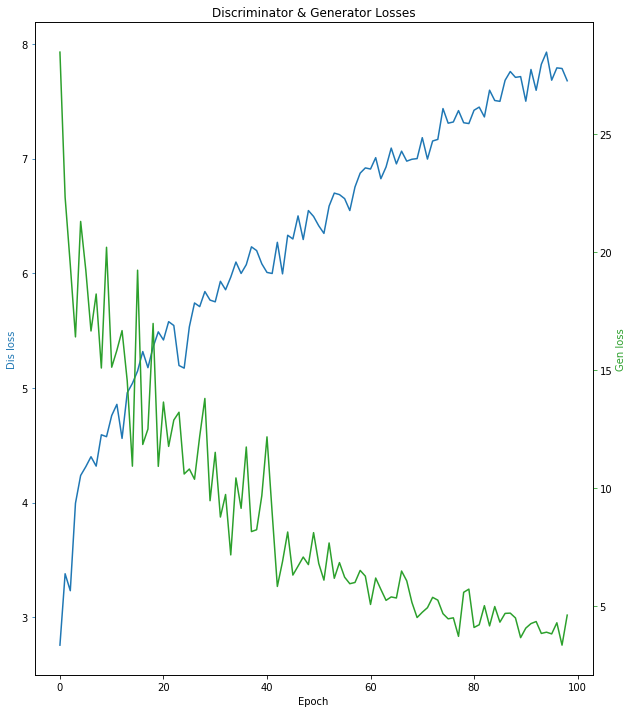


 8.022155 4.687079
--------------- Epoch 101 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 8.124544 3.4156818
--------------- Epoch 102 ---------------




 7.9841094 3.5891685
--------------- Epoch 103 ---------------




 8.0234585 3.8635356
--------------- Epoch 104 ---------------




 8.256477 3.6373036
--------------- Epoch 105 ---------------




 7.8992987 3.5507698
--------------- Epoch 106 ---------------




 8.117608 3.9076722
--------------- Epoch 107 ---------------




 7.8542185 5.039047
--------------- Epoch 108 ---------------




 8.10062 3.9393673
--------------- Epoch 109 ---------------




 8.241583 3.4313307
--------------- Epoch 110 ---------------




 8.044952 3.7073452
--------------- Epoch 111 ---------------




 8.348383 4.1890035
--------------- Epoch 112 ---------------




 7.977541 3.960012
--------------- Epoch 113 ---------------




 8.283033 4.0728855
--------------- Epoch 114 ---------------




 8.369875 4.2672434
--------------- Epoch 115 ---------------




 8.321239 3.9587016
--------------- Epoch 116 ---------------




 8.428776 3.5795107
--------------- Epoch 117 ---------------




 8.317434 3.3728383
--------------- Epoch 118 ---------------




 8.383566 3.891019
--------------- Epoch 119 ---------------




 8.477158 3.514176
--------------- Epoch 120 ---------------




 8.472693 3.606585
--------------- Epoch 121 ---------------




 8.470577 3.0630226
--------------- Epoch 122 ---------------




 8.512867 3.662208
--------------- Epoch 123 ---------------




 8.573194 3.2226381
--------------- Epoch 124 ---------------




 8.554455 3.0836346
--------------- Epoch 125 ---------------




 8.679174 3.9058707
--------------- Epoch 126 ---------------




 8.779568 2.9762135
--------------- Epoch 127 ---------------




 8.412817 4.0980883
--------------- Epoch 128 ---------------




 8.730997 3.1842625
--------------- Epoch 129 ---------------




 8.619524 2.98243
--------------- Epoch 130 ---------------




 8.685446 3.451918
--------------- Epoch 131 ---------------




 8.69574 3.3217006
--------------- Epoch 132 ---------------




 8.79862 3.3521817
--------------- Epoch 133 ---------------




 8.589317 2.9848113
--------------- Epoch 134 ---------------




 8.647556 3.2147894
--------------- Epoch 135 ---------------




 8.759846 3.0716398
--------------- Epoch 136 ---------------




 8.936615 3.6777508
--------------- Epoch 137 ---------------




 8.970091 3.25024
--------------- Epoch 138 ---------------




 8.853151 2.9090765
--------------- Epoch 139 ---------------




 8.807554 2.684687
--------------- Epoch 140 ---------------




 9.085591 2.6620762
--------------- Epoch 141 ---------------




 9.041172 2.7736762
--------------- Epoch 142 ---------------




 8.804087 5.4337296
--------------- Epoch 143 ---------------




 4.7919865 11.904367
--------------- Epoch 144 ---------------




 5.564046 11.030965
--------------- Epoch 145 ---------------




 5.295603 7.712939
--------------- Epoch 146 ---------------




 5.6339326 4.7872066
--------------- Epoch 147 ---------------




 6.1709275 5.3056207
--------------- Epoch 148 ---------------




 5.962719 4.35993
--------------- Epoch 149 ---------------




 6.20746 4.5173235
--------------- Epoch 150 ---------------




 6.456473 3.9693623
--------------- Epoch 151 ---------------




 6.41236 4.6711245
--------------- Epoch 152 ---------------




 5.77296 3.3659306
--------------- Epoch 153 ---------------




 6.4339657 3.1165223
--------------- Epoch 154 ---------------




 6.3996673 3.213674
--------------- Epoch 155 ---------------




 5.767496 3.4204736
--------------- Epoch 156 ---------------




 6.4750905 3.7816448
--------------- Epoch 157 ---------------




 6.2203927 3.1125164
--------------- Epoch 158 ---------------




 6.2465596 3.3692224
--------------- Epoch 159 ---------------




 6.1296763 3.0444853
--------------- Epoch 160 ---------------




 6.57586 3.1176636
--------------- Epoch 161 ---------------




 6.79283 3.0016732
--------------- Epoch 162 ---------------




 6.511755 3.2365344
--------------- Epoch 163 ---------------




 6.9995766 3.4418454
--------------- Epoch 164 ---------------




 6.4429016 2.7268827
--------------- Epoch 165 ---------------




 6.036784 3.0490606
--------------- Epoch 166 ---------------




 6.911265 2.771025
--------------- Epoch 167 ---------------




 6.724078 3.2607517
--------------- Epoch 168 ---------------




 6.6407003 3.8238695
--------------- Epoch 169 ---------------




 6.5527844 3.2289433
--------------- Epoch 170 ---------------




 6.614071 2.89433
--------------- Epoch 171 ---------------




 6.7587986 4.1286917
--------------- Epoch 172 ---------------




 6.8738375 2.9998927
--------------- Epoch 173 ---------------




 6.488042 2.5548482
--------------- Epoch 174 ---------------




 7.198928 2.9802377
--------------- Epoch 175 ---------------




 7.2709785 2.3689973
--------------- Epoch 176 ---------------




 7.4620576 2.7677636
--------------- Epoch 177 ---------------




 7.135866 2.8213627
--------------- Epoch 178 ---------------




 6.7490177 2.5372708
--------------- Epoch 179 ---------------




 6.8749056 3.0933976
--------------- Epoch 180 ---------------




 7.2184467 3.2534027
--------------- Epoch 181 ---------------




 7.424751 3.1591628
--------------- Epoch 182 ---------------




 7.2770944 2.594816
--------------- Epoch 183 ---------------




 7.2443023 2.7291691
--------------- Epoch 184 ---------------




 6.8807573 2.6562638
--------------- Epoch 185 ---------------




 7.3972154 2.6514757
--------------- Epoch 186 ---------------




 7.3380914 2.6050482
--------------- Epoch 187 ---------------




 7.1832104 3.2966511
--------------- Epoch 188 ---------------




 7.4815817 2.7015505
--------------- Epoch 189 ---------------




 7.3702526 3.0783985
--------------- Epoch 190 ---------------




 7.182835 2.4212492
--------------- Epoch 191 ---------------




 7.692976 2.413746
--------------- Epoch 192 ---------------




 6.8567524 3.097881
--------------- Epoch 193 ---------------




 7.3769045 3.547768
--------------- Epoch 194 ---------------




 6.98765 3.447866
--------------- Epoch 195 ---------------




 6.9178057 3.029993
--------------- Epoch 196 ---------------




 7.165496 2.8701143
--------------- Epoch 197 ---------------




 7.6036663 3.4887795
--------------- Epoch 198 ---------------




 7.693489 2.402131
--------------- Epoch 199 ---------------




 7.094369 2.9354174
--------------- Epoch 200 ---------------


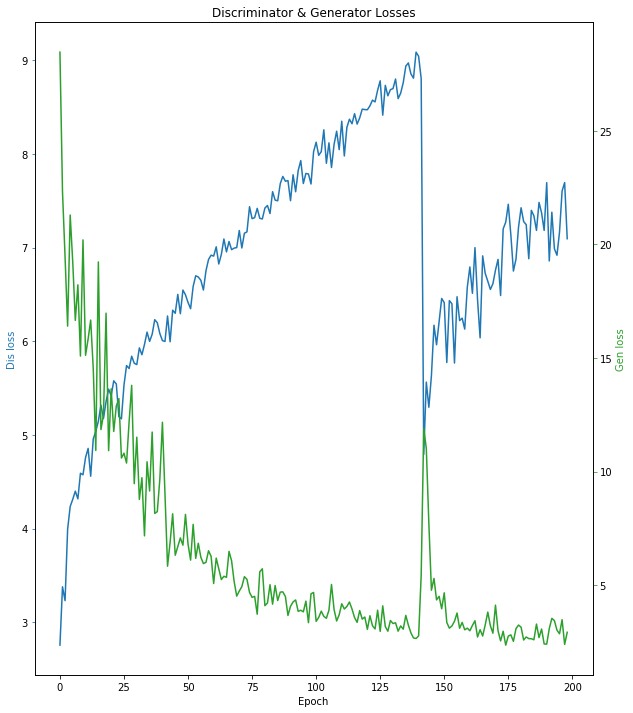


 7.6139975 2.6054492
--------------- Epoch 201 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 7.6634035 2.5702388
--------------- Epoch 202 ---------------




 7.021227 2.8430092
--------------- Epoch 203 ---------------




 7.1663113 2.9318397
--------------- Epoch 204 ---------------




 7.55189 2.7767165
--------------- Epoch 205 ---------------




 7.3143373 2.7127266
--------------- Epoch 206 ---------------




 7.580101 2.1565983
--------------- Epoch 207 ---------------




 7.879344 2.245802
--------------- Epoch 208 ---------------




 7.5811057 2.5771337
--------------- Epoch 209 ---------------




 7.8061085 2.5290499
--------------- Epoch 210 ---------------




 7.74813 2.9811435
--------------- Epoch 211 ---------------




 7.008314 3.3012605
--------------- Epoch 212 ---------------




 8.025263 3.0961843
--------------- Epoch 213 ---------------




 7.594804 2.3622015
--------------- Epoch 214 ---------------




 7.775174 2.8107586
--------------- Epoch 215 ---------------




 8.163592 2.3361588
--------------- Epoch 216 ---------------




 7.2103605 2.5222514
--------------- Epoch 217 ---------------




 8.027433 2.3330314
--------------- Epoch 218 ---------------




 7.652853 2.1564164
--------------- Epoch 219 ---------------




 8.249001 2.6437912
--------------- Epoch 220 ---------------




 8.146395 2.6209495
--------------- Epoch 221 ---------------




 7.656651 2.4545105
--------------- Epoch 222 ---------------




 8.345079 2.380754
--------------- Epoch 223 ---------------




 7.9007173 2.6915956
--------------- Epoch 224 ---------------




 8.369739 2.4470873
--------------- Epoch 225 ---------------




 7.9039865 2.5642984
--------------- Epoch 226 ---------------




 7.7983427 2.430187
--------------- Epoch 227 ---------------




 7.705199 2.7597158
--------------- Epoch 228 ---------------




 8.21731 2.2034333
--------------- Epoch 229 ---------------




 8.009893 2.1523604
--------------- Epoch 230 ---------------




 8.080919 2.0219178
--------------- Epoch 231 ---------------




 8.431786 2.2632556
--------------- Epoch 232 ---------------




 8.377383 1.9325738
--------------- Epoch 233 ---------------




 8.13255 2.3916948
--------------- Epoch 234 ---------------




 8.808739 9.534939
--------------- Epoch 235 ---------------




 8.2511425 9.788929
--------------- Epoch 236 ---------------




 8.47558 8.766997
--------------- Epoch 237 ---------------




 8.537939 6.0847206
--------------- Epoch 238 ---------------




 8.127068 7.142219
--------------- Epoch 239 ---------------




 8.825127 5.55107
--------------- Epoch 240 ---------------




 8.427505 5.563072
--------------- Epoch 241 ---------------




 8.776717 4.2884517
--------------- Epoch 242 ---------------




 8.942009 3.7966628
--------------- Epoch 243 ---------------




 8.072257 4.442665
--------------- Epoch 244 ---------------




 8.702433 5.4881024
--------------- Epoch 245 ---------------




 8.482658 4.9969597
--------------- Epoch 246 ---------------




 8.793443 3.856803
--------------- Epoch 247 ---------------




 7.82405 4.642539
--------------- Epoch 248 ---------------




 8.721546 3.3258333
--------------- Epoch 249 ---------------




 9.054919 3.6416118
--------------- Epoch 250 ---------------




 8.109204 3.1630743
--------------- Epoch 251 ---------------




 9.079603 2.7510564
--------------- Epoch 252 ---------------




 9.017893 10.024739
--------------- Epoch 253 ---------------




 8.603139 5.8817964
--------------- Epoch 254 ---------------




 9.110856 4.773817
--------------- Epoch 255 ---------------




 8.801182 3.9759388
--------------- Epoch 256 ---------------




 8.242365 3.1476817
--------------- Epoch 257 ---------------




 9.106117 3.2383618
--------------- Epoch 258 ---------------




 8.743397 2.9787438
--------------- Epoch 259 ---------------




 9.082911 2.6980684
--------------- Epoch 260 ---------------




 9.132417 3.0745847
--------------- Epoch 261 ---------------




 8.942274 3.2163932
--------------- Epoch 262 ---------------




 8.9981365 2.7894504
--------------- Epoch 263 ---------------




 9.358198 2.8148654
--------------- Epoch 264 ---------------




 9.131016 2.8903787
--------------- Epoch 265 ---------------




 9.266016 2.8961284
--------------- Epoch 266 ---------------




 9.040675 2.664875
--------------- Epoch 267 ---------------




 8.573799 2.730414
--------------- Epoch 268 ---------------




 9.165794 3.0711973
--------------- Epoch 269 ---------------




 8.725422 2.9010482
--------------- Epoch 270 ---------------




 9.062431 3.0520449
--------------- Epoch 271 ---------------




 9.055841 2.7357044
--------------- Epoch 272 ---------------




 9.304059 2.604363
--------------- Epoch 273 ---------------




 9.268776 2.4351208
--------------- Epoch 274 ---------------




 9.21805 2.6971455
--------------- Epoch 275 ---------------




 8.938614 2.66768
--------------- Epoch 276 ---------------




 9.208607 2.680488
--------------- Epoch 277 ---------------




 9.859234 2.4515896
--------------- Epoch 278 ---------------




 9.510639 2.2181609
--------------- Epoch 279 ---------------




 9.343038 2.9028385
--------------- Epoch 280 ---------------




 9.831107 3.0903425
--------------- Epoch 281 ---------------




 9.225577 2.70419
--------------- Epoch 282 ---------------




 9.395872 2.361952
--------------- Epoch 283 ---------------




 9.703549 2.6621492
--------------- Epoch 284 ---------------




 9.079422 2.4020364
--------------- Epoch 285 ---------------




 9.42664 2.0331352
--------------- Epoch 286 ---------------




 9.783882 2.1178713
--------------- Epoch 287 ---------------




 9.444355 2.0957117
--------------- Epoch 288 ---------------




 8.743709 1.9963533
--------------- Epoch 289 ---------------




 8.465464 2.5833678
--------------- Epoch 290 ---------------




 9.400559 2.05406
--------------- Epoch 291 ---------------




 9.3474045 2.4960015
--------------- Epoch 292 ---------------




 9.79614 2.2914696
--------------- Epoch 293 ---------------




 9.730651 2.1095142
--------------- Epoch 294 ---------------




 9.625278 2.207332
--------------- Epoch 295 ---------------




 9.673161 2.5336359
--------------- Epoch 296 ---------------




 9.94725 2.3535538
--------------- Epoch 297 ---------------




 9.7804985 2.261176
--------------- Epoch 298 ---------------




 9.753707 2.2920675
--------------- Epoch 299 ---------------




 9.72919 2.2400496
--------------- Epoch 300 ---------------


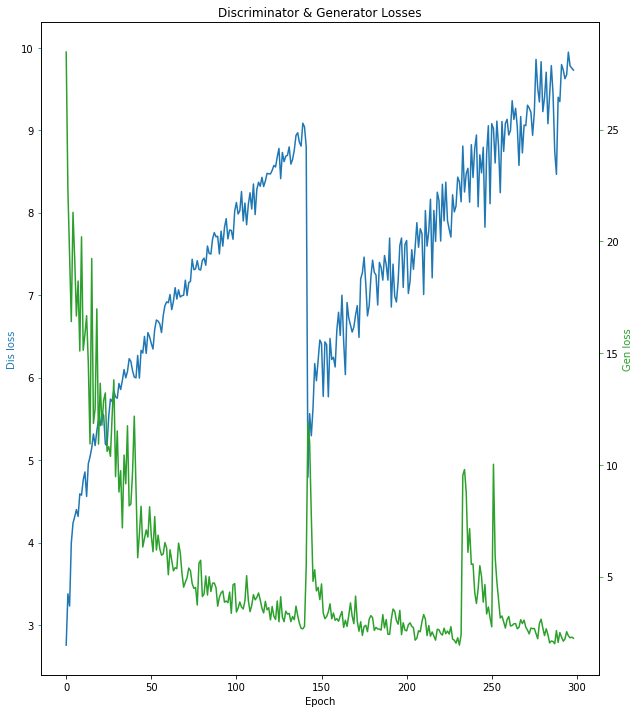


 9.940839 2.447714
--------------- Epoch 301 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 9.706585 1.7628609
--------------- Epoch 302 ---------------




 9.2203045 2.0860863
--------------- Epoch 303 ---------------




 10.016727 2.359129
--------------- Epoch 304 ---------------




 9.627555 1.8033795
--------------- Epoch 305 ---------------




 9.812305 2.0290823
--------------- Epoch 306 ---------------




 9.759239 2.6502094
--------------- Epoch 307 ---------------




 9.591275 2.6028655
--------------- Epoch 308 ---------------




 10.104503 2.076024
--------------- Epoch 309 ---------------




 9.594585 2.2253764
--------------- Epoch 310 ---------------




 9.861515 1.9072704
--------------- Epoch 311 ---------------




 10.104086 2.1274538
--------------- Epoch 312 ---------------




 9.451443 2.0313523
--------------- Epoch 313 ---------------




 10.082193 4.380593
--------------- Epoch 314 ---------------




 9.991805 2.3252804
--------------- Epoch 315 ---------------




 10.091099 2.5421374
--------------- Epoch 316 ---------------




 9.902166 2.3336465
--------------- Epoch 317 ---------------




 9.413667 2.2568517
--------------- Epoch 318 ---------------




 9.962181 2.1134725
--------------- Epoch 319 ---------------




 10.13011 2.622703
--------------- Epoch 320 ---------------




 9.9948845 2.4749691
--------------- Epoch 321 ---------------




 10.196716 2.099285
--------------- Epoch 322 ---------------




 9.906019 2.3749034
--------------- Epoch 323 ---------------




 10.140261 2.1320832
--------------- Epoch 324 ---------------




 10.140303 2.4351974
--------------- Epoch 325 ---------------




 9.796311 2.311555
--------------- Epoch 326 ---------------




 10.401064 2.0710378
--------------- Epoch 327 ---------------




 10.191987 1.9263825
--------------- Epoch 328 ---------------




 9.683119 2.2742467
--------------- Epoch 329 ---------------




 10.412974 2.0966697
--------------- Epoch 330 ---------------




 9.966957 2.690371
--------------- Epoch 331 ---------------




 10.270525 2.1944542
--------------- Epoch 332 ---------------




 10.249275 1.842164
--------------- Epoch 333 ---------------




 10.229494 1.9820423
--------------- Epoch 334 ---------------




 9.743519 2.4723508
--------------- Epoch 335 ---------------




 10.242313 2.0525753
--------------- Epoch 336 ---------------




 10.658361 1.7178594
--------------- Epoch 337 ---------------




 10.2090435 2.4848473
--------------- Epoch 338 ---------------




 10.608618 1.9153978
--------------- Epoch 339 ---------------




 10.188032 2.032584
--------------- Epoch 340 ---------------




 10.143634 2.1162536
--------------- Epoch 341 ---------------




 10.482814 2.0899363
--------------- Epoch 342 ---------------




 10.332682 1.6421918
--------------- Epoch 343 ---------------




 10.089668 2.0999084
--------------- Epoch 344 ---------------




 10.49458 2.3743126
--------------- Epoch 345 ---------------




 10.021336 1.9465542
--------------- Epoch 346 ---------------




 9.977494 1.8700889
--------------- Epoch 347 ---------------




 10.329183 2.152711
--------------- Epoch 348 ---------------




 10.319834 2.4340758
--------------- Epoch 349 ---------------




 10.436407 1.9983023
--------------- Epoch 350 ---------------




 10.53907 2.3807924


In [0]:
#shutil.move('/content/srgan_weights_epoch_40.h5', os.getcwd())

model_srgan.train(350, save_interval=100 ,batch_size=16)

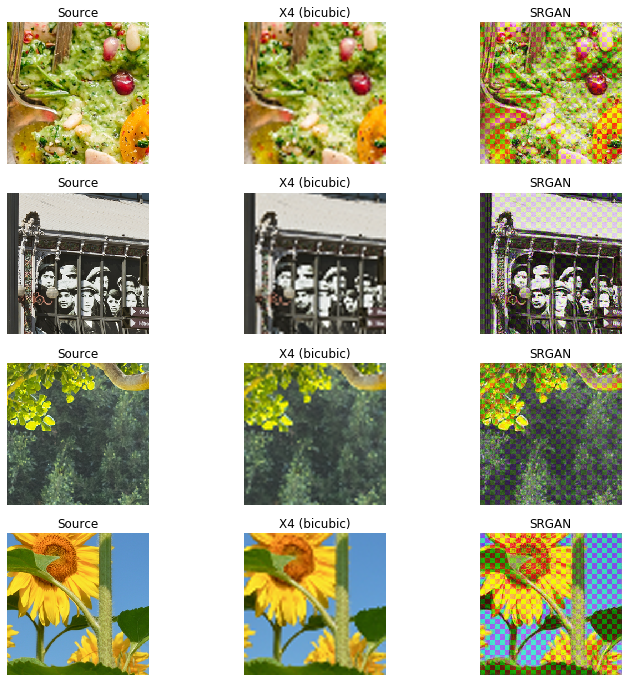

In [0]:
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [0]:
model_srgan.srgan.load_weights('/content/training_process/srgan_weights_epoch_200.h5')

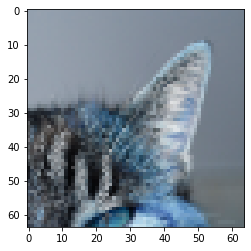

In [0]:
img1 = cv2.imread('/content/0869x4-crop.png')
#img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_low_input_list=[]
img_low_input_list.append(cv2.resize(img1,(64,64)))
img2=np.array(img_low_input_list)
plt.imshow(img2[0])

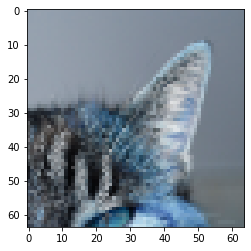

In [0]:
img3=np.array(img_low_input_list)
plt.imshow(img2[0])

In [0]:
img3=np.array(img_low_input_list)
plt.imshow(img2[0])

In [0]:
img2[0].shape

(64, 64, 3)

In [0]:
generated_hr_img1 = model_srgan.generator.predict(np.expand_dims(img2[0], axis = 0) / 127.5 - 1)

Text(0.5, 1.0, 'SRGAN')

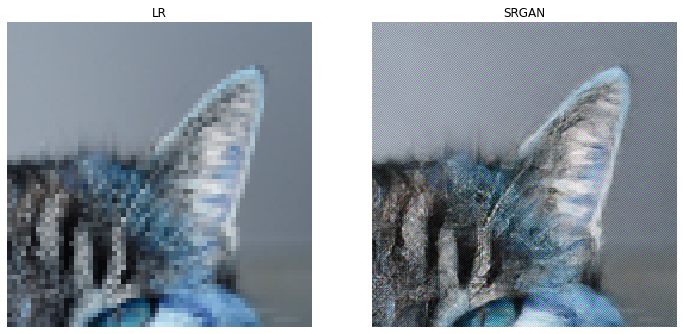

In [0]:
plt.figure(figsize = (12,12))
plt.subplot(1,2,1)
#plt.imshow(cv2.resize(img3[0],(256,256),interpolation = cv2.INTER_CUBIC))
plt.imshow(img3[0])
plt.grid('off')
plt.axis('off')
plt.title('LR')

plt.subplot(1,2,2)
img_unnorm1 = (generated_hr_img1+1) * 127.5
plt.imshow(np.squeeze(img_unnorm1, axis = 0).astype(np.uint8))
plt.grid('off')
plt.axis('off')
plt.title('SRGAN')